In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pickle, time

# pd.set_option("display.max_columns", 100)

In [2]:
total_df = pd.read_csv("filtered_data/Filtered_data.csv") # total dataset
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(total_df))

signal = pd.read_csv("../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated signal events: ", len(signal))

#prepare the signal
K_ProbNNp = signal["K_MC15TuneV1_ProbNNp"]
K_probNNk = signal["K_MC15TuneV1_ProbNNk"]
Pi_ProbNNp = signal["Pi_MC15TuneV1_ProbNNp"]
Pi_probNNk = signal["Pi_MC15TuneV1_ProbNNk"]
Pi_ProbNNpi = signal["Pi_MC15TuneV1_ProbNNpi"]

signal['accept_kaon'] = K_probNNk * (1 - K_ProbNNp)
signal['accept_pion'] = Pi_ProbNNpi * (1 - Pi_probNNk) * (1 - Pi_ProbNNp)
signal['accept_muon'] = signal[['mu_plus_MC15TuneV1_ProbNNmu', 'mu_minus_MC15TuneV1_ProbNNmu']].max(axis=1)


bg = pd.read_csv("peaking_bg_filtered/pKmumu_piTop.csv")
print("Number of background events: ", len(bg))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes

Total dataset number of events:  38269
Number of simulated signal events:  8802
Number of background events:  56
Length of labels array 8858


In [3]:
to_leave = set(['mu_plus_P', 'mu_plus_PT', 'mu_plus_ETA', 'mu_plus_PHI', 'mu_plus_PE',
       'mu_plus_PX', 'mu_plus_PY', 'mu_plus_PZ', 'mu_plus_IPCHI2_OWNPV',
       'mu_minus_P', 'mu_minus_PT', 'mu_minus_ETA', 'mu_minus_PHI',
       'mu_minus_PE', 'mu_minus_PX', 'mu_minus_PY', 'mu_minus_PZ',
       'mu_minus_IPCHI2_OWNPV', 'K_P', 'K_PT', 'K_ETA', 'K_PHI', 'K_PE',
       'K_PX', 'K_PY', 'K_PZ', 'K_IPCHI2_OWNPV', 'Pi_P', 'Pi_PT', 'Pi_ETA',
       'Pi_PHI', 'Pi_PE', 'Pi_PX', 'Pi_PY', 'Pi_PZ', 'Pi_IPCHI2_OWNPV',
       'B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF', 'B0_FDCHI2_OWNPV', 'Kstar_MM',
       'Kstar_ENDVERTEX_CHI2', 'Kstar_ENDVERTEX_NDOF', 'Kstar_FDCHI2_OWNPV',
       'J_psi_MM', 'J_psi_ENDVERTEX_CHI2', 'J_psi_ENDVERTEX_NDOF',
       'J_psi_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X',
       'B0_OWNPV_Y', 'B0_OWNPV_Z', 'B0_FD_OWNPV', 'accept_kaon', 'accept_pion', 'accept_muon', 'B0_MM'])

to_drop = list(set(X.columns) - to_leave)

X = X.drop(to_drop, axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data

Y = vals

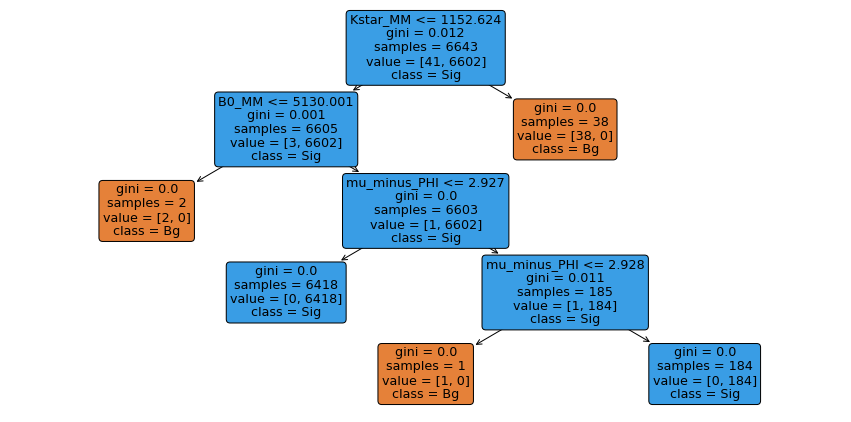

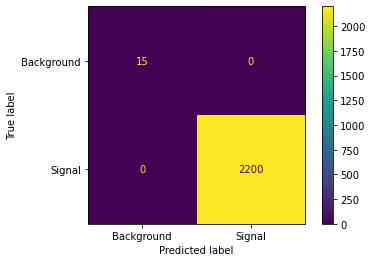

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

<h3>End of investigation</h3>

In [5]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

print(ccp_alphas)
print(len(ccp_alphas))

[0.         0.00015051 0.00060177]
3


Starting alpha num:  0
Execution time for alpha:  0.5390126705169678
Starting alpha num:  1
Execution time for alpha:  0.5500566959381104
Starting alpha num:  2
Execution time for alpha:  0.5500361919403076
Total execution time:  1.6400856971740723


<AxesSubplot:xlabel='alpha'>

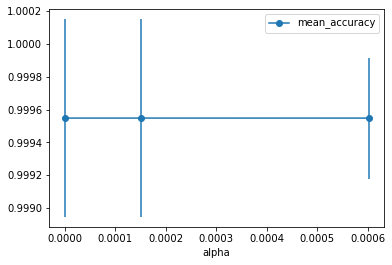

In [6]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
init_time = time.time()
for num, ccp_alpha in enumerate(ccp_alphas): # not all alphas are used to save some time - for better precision all ccp_alphas should be looked at
    print("Starting alpha num: ", num)
    start_time = time.time()
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    print("Execution time for alpha: ", time.time() - start_time)
print("Total execution time: ", time.time() - init_time)
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

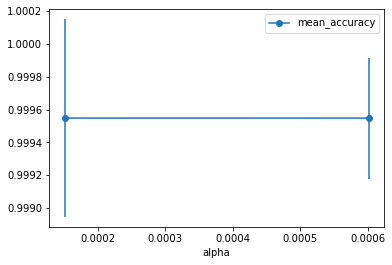

In [7]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[1:].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


0.0006017729466278133


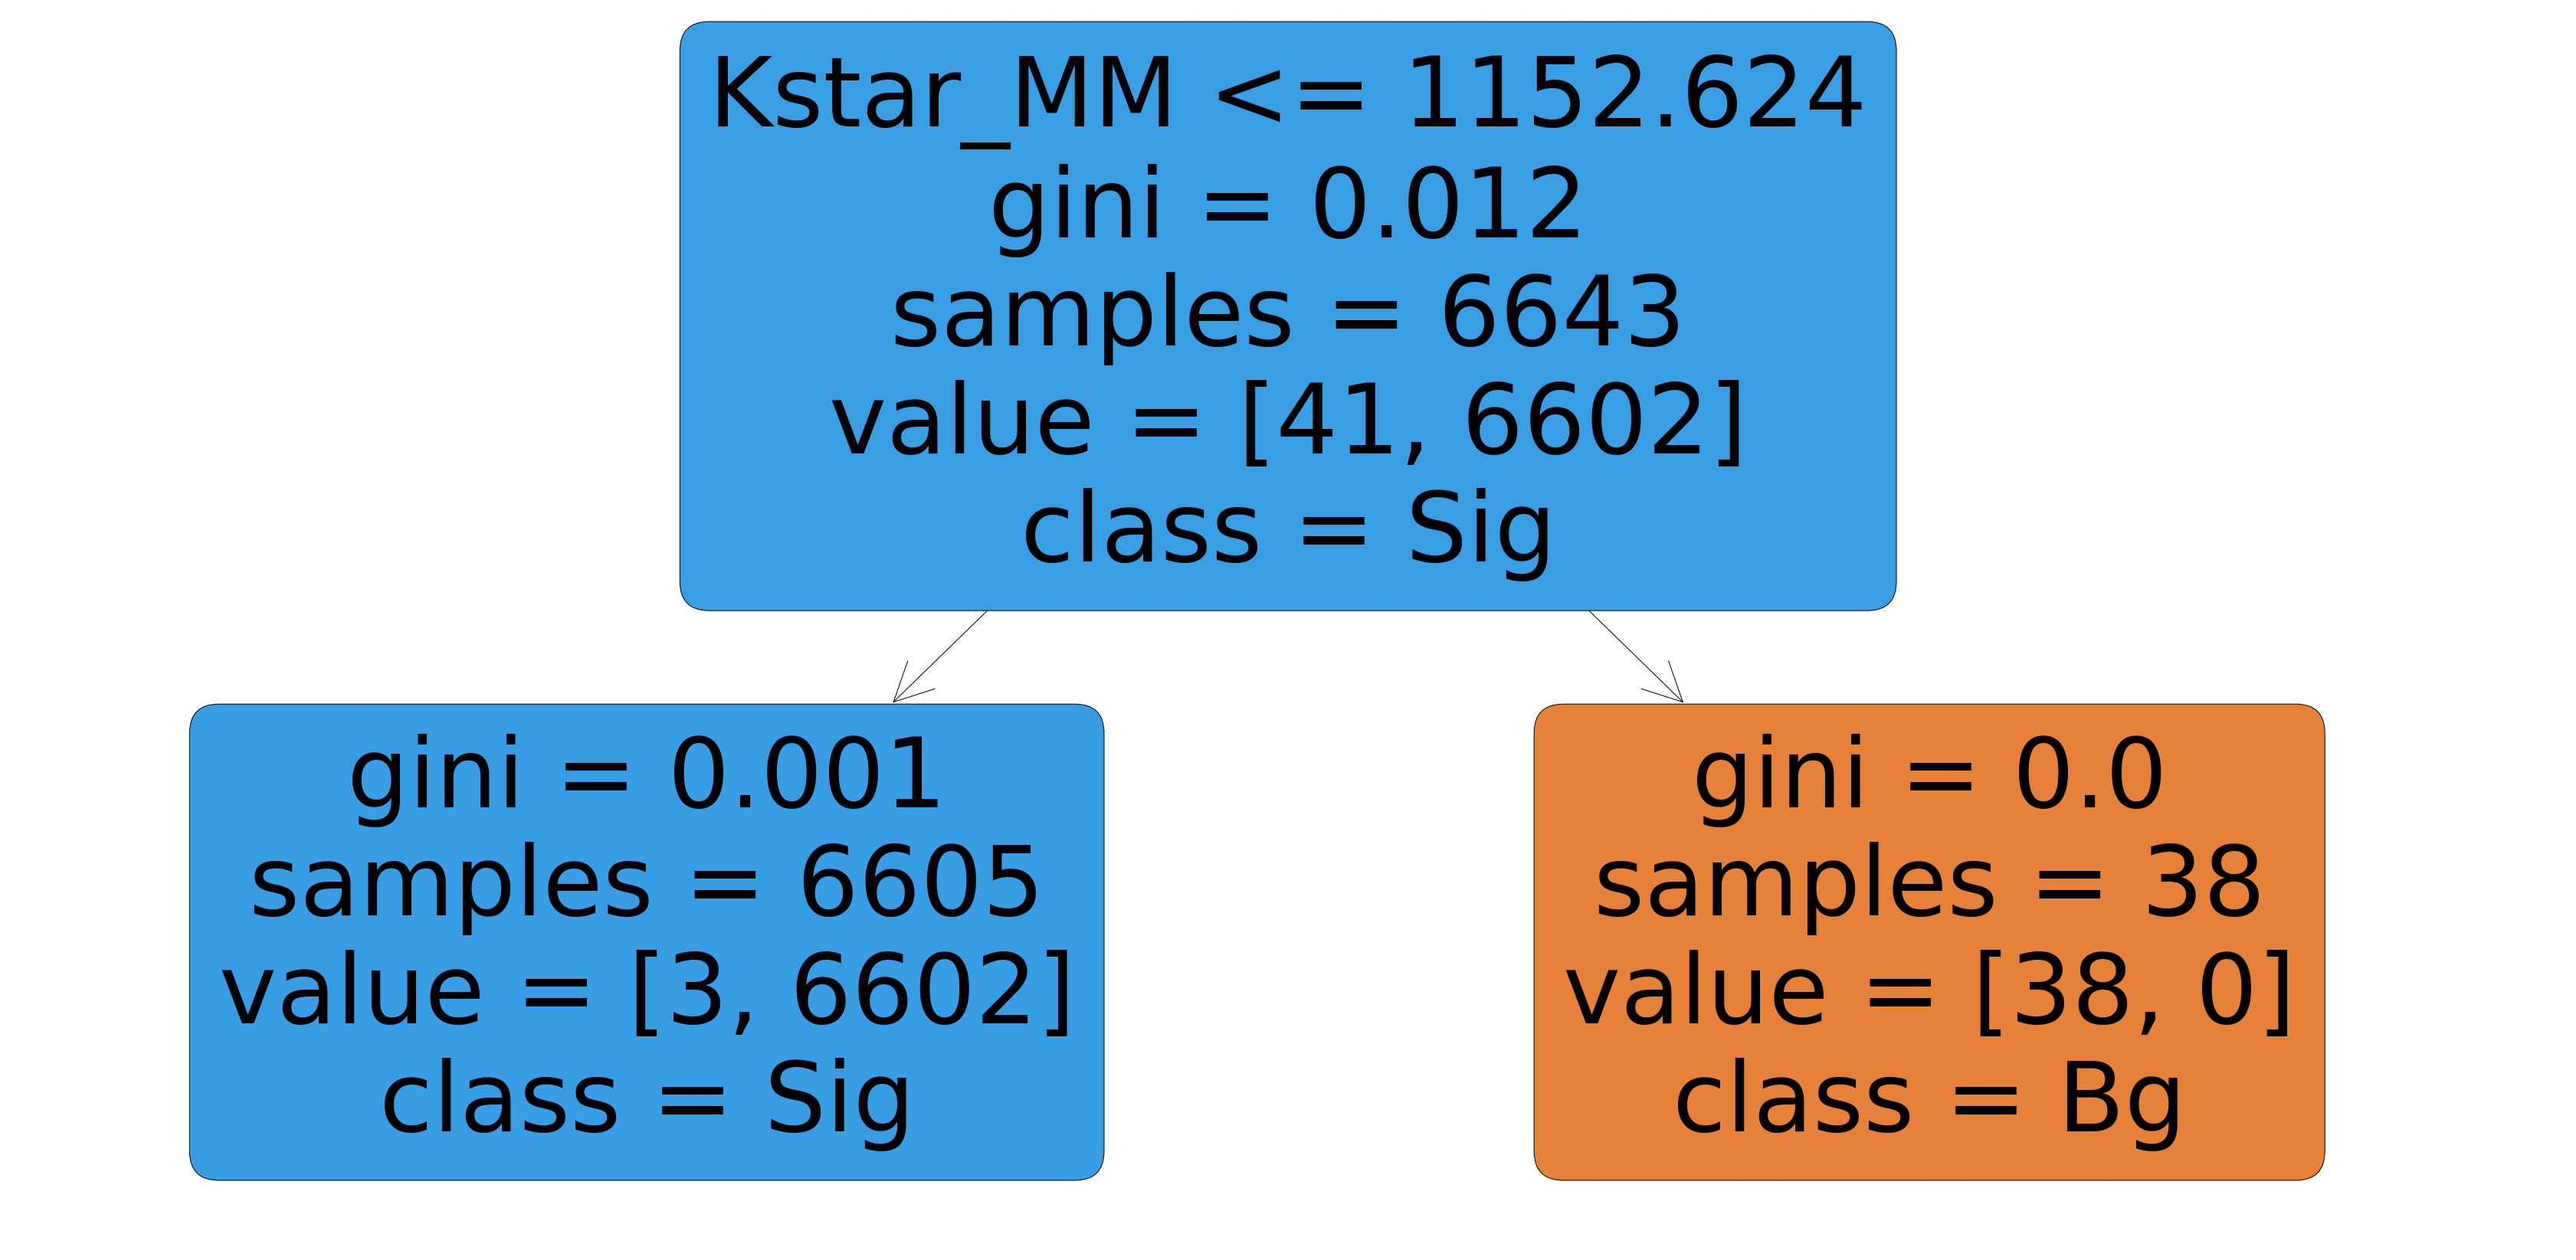

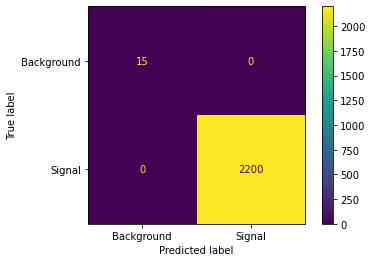

In [8]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.0005) & (ccp_alphas < 0.0007)][0]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (60, 30))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

In [9]:
"""
0% false-positive (100% of bg is filtered out)
0% false-negative
"""

with open("trees/tree_pKmumu_piTop", 'wb') as f: # exporting decision tree to 'tree_jpsi' binary file
    pickle.dump(clf_dt, f)

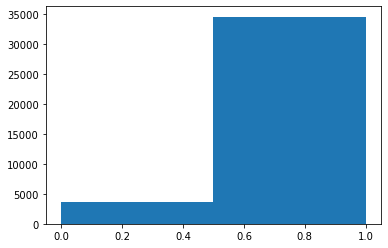

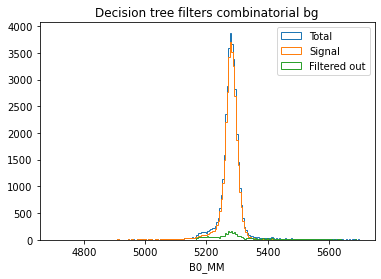

In [10]:
data = X
model = None
with open("trees/tree_pKmumu_piTop", 'rb') as f:
    model = pickle.load(f)
    

to_leave = set(['mu_plus_P', 'mu_plus_PT', 'mu_plus_ETA', 'mu_plus_PHI', 'mu_plus_PE',
       'mu_plus_PX', 'mu_plus_PY', 'mu_plus_PZ', 'mu_plus_IPCHI2_OWNPV',
       'mu_minus_P', 'mu_minus_PT', 'mu_minus_ETA', 'mu_minus_PHI',
       'mu_minus_PE', 'mu_minus_PX', 'mu_minus_PY', 'mu_minus_PZ',
       'mu_minus_IPCHI2_OWNPV', 'K_P', 'K_PT', 'K_ETA', 'K_PHI', 'K_PE',
       'K_PX', 'K_PY', 'K_PZ', 'K_IPCHI2_OWNPV', 'Pi_P', 'Pi_PT', 'Pi_ETA',
       'Pi_PHI', 'Pi_PE', 'Pi_PX', 'Pi_PY', 'Pi_PZ', 'Pi_IPCHI2_OWNPV',
       'B0_ENDVERTEX_CHI2', 'B0_ENDVERTEX_NDOF', 'B0_FDCHI2_OWNPV', 'Kstar_MM',
       'Kstar_ENDVERTEX_CHI2', 'Kstar_ENDVERTEX_NDOF', 'Kstar_FDCHI2_OWNPV',
       'J_psi_MM', 'J_psi_ENDVERTEX_CHI2', 'J_psi_ENDVERTEX_NDOF',
       'J_psi_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'B0_DIRA_OWNPV', 'B0_OWNPV_X',
       'B0_OWNPV_Y', 'B0_OWNPV_Z', 'B0_FD_OWNPV', 'accept_kaon', 'accept_pion', 'accept_muon', 'B0_MM'])

to_drop = set(total_df.columns) - to_leave

predict_df = total_df.drop(to_drop, axis = 1)

res = model.predict(predict_df)


plt.hist(res, bins = 2)
plt.show()

total_df["res"] = res

plt.title("Decision tree filters combinatorial bg")
plt.hist(total_df["B0_MM"], bins = 200, histtype = "step", label = "Total")
plt.hist(total_df[total_df["res"] == 1]["B0_MM"], bins = 200, histtype = "step", label = "Signal")
plt.hist(total_df[total_df["res"] == 0]["B0_MM"], bins = 200, histtype = "step", label = "Filtered out")
plt.xlabel("B0_MM")
plt.legend()
plt.show()